# Tutorial: PyTorch

In [1]:
__author__ = "Ignacio Cases"
__version__ = "CS224U, Stanford, Fall 2020"

## Contents

1. [Motivation](#Motivation)
1. [Importing PyTorch](#Importing-PyTorch)
1. [Tensors](#Tensors)
  1. [Tensor creation](#Tensor-creation)
  1. [Operations on tensors](#Operations-on-tensors)
1. [GPU computation](#GPU-computation)
1. [Neural network foundations](#Neural-network-foundations)
  1. [Automatic differentiation](#Automatic-differentiation)
  1. [Modules](#Modules)
  1. [Sequential](#Sequential)
  1. [Criteria and loss functions](#Criteria-and-loss-functions)
  1. [Optimization](#Optimization)
  1. [Training a simple model](#Training-a-simple-model)
1. [Reproducibility](#Reproducibility)
1. [References](#References)

## Motivation

PyTorch is a Python package designed to carry out scientific computation. We use PyTorch in a range of different environments: local model development, large-scale deployments on big clusters, and even _inference_ in embedded, low-power systems. While similar in many aspects to NumPy, PyTorch enables us to perform fast and efficient training of deep learning and reinforcement learning models not only on the CPU but also on a GPU or other ASICs (Application Specific Integrated Circuits) for AI, such as Tensor Processing Units (TPU).

## Importing PyTorch

This tutorial assumes a working installation of PyTorch using your `nlu` environment, but the content applies to any regular installation of PyTorch. If you don't have a working installation of PyTorch, please follow the instructions in [the setup notebook](setup.ipynb).

To get started working with PyTorch we simply begin by importing the torch module:

In [2]:
import torch

**Side note**: why not `import pytorch`? The name of the package is `torch` for historical reasons: `torch` is the orginal name of the ancestor of the PyTorch library that got started back in 2002 as a C library with Lua scripting. It was only much later that the original `torch` was ported to Python. The PyTorch project decided to prefix the Py to make clear that this library refers to the Python version, as it was confusing back then to know which `torch` one was referring to. All the internal references to the library use just `torch`. It's possible that PyTorch will be renamed at some point, as the original `torch` is no longer maintained and there is no longer confusion.

We can see the version installed and determine whether or not we have a GPU-enabled PyTorch install by issuing

In [3]:
print("PyTorch version {}".format(torch.__version__))
print("GPU-enabled installation? {}".format(torch.cuda.is_available()))

PyTorch version 1.4.0
GPU-enabled installation? False


PyTorch has good [documentation](https://pytorch.org/docs/stable/index.html) but it can take some time to familiarize oneself with the structure of the package; it's worth the effort to do so!

We will also make use of other imports:

In [4]:
import numpy as np

## Tensors

Tensors collections of numbers represented as an array, and are the basic building blocks in PyTorch.

You are probably already familiar with several types of tensors:
    
- A scalar, a single number, is a zero-th order tensor.
    
- A column vector $v$ of dimensionality $d_c \times 1$ is a tensor of order 1.
    
- A row vector $x$ of dimensionality $1 \times d_r$ is a tensor of order 1.
    
- A matrix $A$ of dimensionality $d_r \times d_c$ is a tensor of order 2.
    
- A cube $T$ of dimensionality $d_r \times d_c \times d_d$ is a tensor of order 3. 

Tensors are the fundamental blocks that carry information in our mathematical models, and they are composed using several operations to create mathematical graphs in which information can flow (propagate) forward (functional application) and backwards (using the chain rule). 

We have seen multidimensional arrays in NumPy. These NumPy objects are also a representation of tensors.

**Side note**: what is a tensor __really__? Tensors are important mathematical objects with applications in multiple domains in mathematics and physics. The term "tensor" comes from the usage of these mathematical objects to describe the stretching of a volume of matter under *tension*. They are central objects of study in a subfield of mathematics known as differential geometry, which deals with the geometry of continuous vector spaces. As a very high-level summary (and as first approximation), tensors are defined as multi-linear "machines" that have a number of slots (their order, a.k.a. rank), taking a number of "column" vectors and "row" vectors *to produce a scalar*. For example, a tensor $\mathbf{A}$ (represented by a matrix with rows and columns that you could write on a sheet of paper) can be thought of having two slots. So when $\mathbf{A}$ acts upon a column vector $\mathbf{v}$ and a row vector $\mathbf{x}$, it returns a scalar:
    
$$\mathbf{A}(\mathbf{x}, \mathbf{v}) = s$$
    
If $\mathbf{A}$ only acts on the column vector, for example, the result will be another column tensor $\mathbf{u}$ of one order less than the order of $\mathbf{A}$. Thus, when $\mathbf{v}$ acts is similar to "removing" its slot: 

$$\mathbf{u} = \mathbf{A}(\mathbf{v})$$

The resulting $\mathbf{u}$ can later interact with another row vector to produce a scalar or be used in any other way. 

This can be a very powerful way of thinking about tensors, as their slots can guide you when writing code, especially given that PyTorch has a _functional_ approach to modules in which this view is very much highlighted. As we will see below, these simple equations above have a completely straightforward representation in the code. In the end, most of what our models will do is to process the input using this type of functional application so that we end up having a tensor output and a scalar value that measures how good our output is with respect to the real output value in the dataset.

### Tensor creation

Let's get started with tensors in PyTorch. The framework supports eight different types ([Lapan 2018](#References)):

- 3 float types (16-bit, 32-bit, 64-bit): `torch.FloatTensor` is the class name for the commonly used 32-bit tensor.
- 5 integer types (signed 8-bit, unsigned 8-bit, 16-bit, 32-bit, 64-bit): common tensors of these types are the 8-bit unsigned tensor `torch.ByteTensor` and the 64-bit `torch.LongTensor`.

There are three fundamental ways to create tensors in PyTorch ([Lapan 2018](#References)):

- Call a tensor constructor of a given type, which will create a non-initialized tensor. So we then need to fill this tensor later to be able to use it.
- Call a built-in method in the `torch` module that returns a tensor that is already initialized.
- Use the PyTorch–NumPy bridge.

#### Calling the constructor

Let's first create a 2 x 3 dimensional tensor of the type `float`:

In [5]:
t = torch.FloatTensor(2, 3)
print(t)
print(t.size())

tensor([[-1.2283e+27,  4.5884e-41, -1.2077e+24],
        [ 4.5884e-41, -1.4031e+27,  4.5884e-41]])
torch.Size([2, 3])


Note that we specified the dimensions as the arguments to the constructor by passing the numbers directly – and not a list or a tuple, which would have very different outcomes as we will see below! We can always inspect the size of the tensor using the `size()` method.

The constructor method allocates space in memory for this tensor. However, the tensor is *non-initialized*. In order to initialize it, we need to call any of the tensor initialization methods of the basic tensor types. For example, the tensor we just created has a built-in method `zero_()`:

In [6]:
t.zero_()

tensor([[0., 0., 0.],
        [0., 0., 0.]])

The underscore after the method name is important: it means that the operation happens _in place_: the returned object is the same object but now with different content. A very handy way to construct a tensor using the constructor happens when we have available the content we want to put in the tensor in the form of a Python iterable. In this case, we just pass it as the argument to the constructor:

In [7]:
torch.FloatTensor([[1, 2, 3], [4, 5, 6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

#### Calling a method in the torch module

A very convenient way to create tensors, in addition to using the constructor method, is to use one of the multiple methods provided in the `torch` module. In particular, the `tensor` method allows us to pass a number or iterable as the argument to get the appropriately typed tensor:

In [8]:
tl = torch.tensor([1, 2, 3])
t = torch.tensor([1., 2., 3.])
print("A 64-bit integer tensor: {}, {}".format(tl, tl.type()))
print("A 32-bit float tensor: {}, {}".format(t, t.type()))

A 64-bit integer tensor: tensor([1, 2, 3]), torch.LongTensor
A 32-bit float tensor: tensor([1., 2., 3.]), torch.FloatTensor


We can create a similar 2x3 tensor to the one above by using the `torch.zeros()` method, passing a sequence of dimensions to it: 

In [9]:
t = torch.zeros(2, 3)
print(t)

tensor([[0., 0., 0.],
        [0., 0., 0.]])


There are many methods for creating tensors. We list some useful ones:

In [10]:
t_zeros = torch.zeros_like(t)        # zeros_like returns a new tensor
t_ones = torch.ones(2, 3)            # creates a tensor with 1s
t_fives = torch.empty(2, 3).fill_(5) # creates a non-initialized tensor and fills it with 5
t_random = torch.rand(2, 3)          # creates a uniform random tensor
t_normal = torch.randn(2, 3)         # creates a normal random tensor

print(t_zeros)
print(t_ones)
print(t_fives)
print(t_random)
print(t_normal)

tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([[1., 1., 1.],
        [1., 1., 1.]])
tensor([[5., 5., 5.],
        [5., 5., 5.]])
tensor([[0.5275, 0.1870, 0.5300],
        [0.1604, 0.1122, 0.3216]])
tensor([[-0.3025, -1.6446, -0.1769],
        [ 1.1837, -1.2383, -0.7167]])


We now see emerging two important paradigms in PyTorch. The _imperative_ approach to performing operations, using _inplace_ methods, is in marked contrast with an additional paradigm also used in PyTorch, the _functional_ approach, where the returned object is a copy of the original object. Both paradigms have their specific use cases as we will be seeing below. The rule of thumb is that _inplace_ methods are faster and don't require extra memory allocation in general, but they can be tricky to understand (keep this in mind regarding the computational graph that we will see below). _Functional_ methods make the code referentially transparent, which is a highly desired property that makes it easier to understand the underlying math, but we rely on the efficiency of the implementation:

In [11]:
# creates a new copy of the tensor that is still linked to 
# the computational graph (see below)
t1 = torch.clone(t)
assert id(t) != id(t1), 'Functional methods create a new copy of the tensor'

# To create a new _independent_ copy, we do need to detach 
# from the graph
t1 = torch.clone(t).detach()

#### Using the PyTorch–NumPy bridge

A quite useful feature of PyTorch is its almost seamless integration with NumPy, which allows us to perform operations on NumPy and interact from PyTorch with the large number of NumPy libraries as well. Converting a NumPy multi-dimensional array into a PyTorch tensor is very simple: we only need to call the `tensor` method with NumPy objects as the argument:

In [12]:
# Create a new multi-dimensional array in NumPy with the np datatype (np.float32)
a = np.array([1., 2., 3.])

# Convert the array to a torch tensor
t = torch.tensor(a)

print("NumPy array: {}, type: {}".format(a, a.dtype))
print("Torch tensor: {}, type: {}".format(t, t.dtype))

NumPy array: [1. 2. 3.], type: float64
Torch tensor: tensor([1., 2., 3.], dtype=torch.float64), type: torch.float64


We can also seamlessly convert a PyTorch tensor into a NumPy array:

In [13]:
t.numpy()

array([1., 2., 3.])

**Side note**: why not `torch.from_numpy(a)`? The `from_numpy()` method is depecrated in favor of `tensor()`, which is a more capable method in the torch package. `from_numpy()` is only there for backwards compatibility. It can be a little bit quirky, so I recommend using the newer method in PyTorch >= 0.4.

#### Indexing



Indexing works as expected with NumPy:

In [14]:
t = torch.randn(2, 3)
t[ : , 0]

tensor([-0.2222,  0.4038])

PyTorch also supports indexing using long tensors, for example:

In [15]:
t = torch.randn(5, 6)
print(t)
i = torch.tensor([1, 3])
j = torch.tensor([4, 5])
print(t[i])                          # selects rows 1 and 3
print(t[i, j])                       # selects (1, 4) and (3, 5)

tensor([[-0.9512,  0.0463,  0.6822,  0.4541,  0.1027, -0.2106],
        [ 0.5921, -0.6410,  1.5878, -0.0321, -0.5603,  0.5489],
        [ 1.0219,  1.5319,  1.5433,  1.1993,  1.7030, -1.4134],
        [-0.8388, -0.4763,  1.1888,  0.7077, -0.2650, -0.1021],
        [-1.0012,  0.9604,  1.0057, -0.9991, -0.7933, -0.7060]])
tensor([[ 0.5921, -0.6410,  1.5878, -0.0321, -0.5603,  0.5489],
        [-0.8388, -0.4763,  1.1888,  0.7077, -0.2650, -0.1021]])
tensor([-0.5603, -0.1021])


#### Type conversion

Each tensor has a set of convenient methods to convert types. For example, if we want to convert the tensor above to a 32-bit float tensor, we use the method `.float()`:

In [16]:
t = t.float()   # converts to 32-bit float
print(t)
t = t.double()  # converts to 64-bit float
print(t)
t = t.byte()    # converts to unsigned 8-bit integer
print(t)

tensor([[-0.9512,  0.0463,  0.6822,  0.4541,  0.1027, -0.2106],
        [ 0.5921, -0.6410,  1.5878, -0.0321, -0.5603,  0.5489],
        [ 1.0219,  1.5319,  1.5433,  1.1993,  1.7030, -1.4134],
        [-0.8388, -0.4763,  1.1888,  0.7077, -0.2650, -0.1021],
        [-1.0012,  0.9604,  1.0057, -0.9991, -0.7933, -0.7060]])
tensor([[-0.9512,  0.0463,  0.6822,  0.4541,  0.1027, -0.2106],
        [ 0.5921, -0.6410,  1.5878, -0.0321, -0.5603,  0.5489],
        [ 1.0219,  1.5319,  1.5433,  1.1993,  1.7030, -1.4134],
        [-0.8388, -0.4763,  1.1888,  0.7077, -0.2650, -0.1021],
        [-1.0012,  0.9604,  1.0057, -0.9991, -0.7933, -0.7060]],
       dtype=torch.float64)
tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   1,   0,   0,   0],
        [  1,   1,   1,   1,   1, 255],
        [  0,   0,   1,   0,   0,   0],
        [255,   0,   1,   0,   0,   0]], dtype=torch.uint8)


### Operations on tensors

Now that we know how to create tensors, let's create some of the fundamental tensors and see some common operations on them:

In [17]:
# Scalars =: creates a tensor with a scalar 
# (zero-th order tensor,  i.e. just a number)
s = torch.tensor(42)
print(s)

tensor(42)


**Tip**: a very convenient to access scalars is with `.item()`:

In [18]:
s.item()

42

Let's see higher-order tensors – remember we can always inspect the dimensionality of a tensor using the `.size()` method:

In [19]:
# Row vector
x = torch.randn(1,3)
print("Row vector\n{}\nwith size {}".format(x, x.size()))

# Column vector
v = torch.randn(3,1)
print("Column vector\n{}\nwith size {}".format(v, v.size()))

# Matrix
A = torch.randn(3, 3)
print("Matrix\n{}\nwith size {}".format(A, A.size()))

Row vector
tensor([[ 2.4337, -1.6546,  1.7862]])
with size torch.Size([1, 3])
Column vector
tensor([[-0.8834],
        [-0.3613],
        [-1.4556]])
with size torch.Size([3, 1])
Matrix
tensor([[ 0.4256,  0.5723, -0.4221],
        [-1.2646,  0.8962,  0.9930],
        [ 0.4961, -0.4934, -2.6406]])
with size torch.Size([3, 3])


A common operation is matrix-vector multiplication (and in general tensor-tensor multiplication). For example, the product $\mathbf{A}\mathbf{v} + \mathbf{b}$ is as follows:

In [20]:
u = torch.matmul(A, v)
print(u)
b = torch.randn(3,1)
y = u + b              # we can also do torch.add(u, b)
print(y)

tensor([[ 0.0317],
        [-0.6520],
        [ 3.5837]])
tensor([[ 0.0774],
        [-1.1959],
        [ 3.1463]])


where we retrieve the expected result (a column vector of dimensions 3x1). We can of course compose operations:

In [21]:
s = torch.matmul(x, torch.matmul(A, v))
print(s.item())

7.557076454162598


There are many functions implemented for every tensor, and we encourage you to study the documentation. Some of the most common ones:

In [22]:
# common tensor methods (they also have the counterpart in 
# the torch package, e.g. as torch.sum(t))
t = torch.randn(2,3)
t.sum(dim=0)                 
t.t()                   # transpose
t.numel()               # number of elements in tensor
t.nonzero()             # indices of non-zero elements
t.view(-1, 2)           # reorganizes the tensor to these dimensions
t.squeeze()             # removes size 1 dimensions
t.unsqueeze(0)          # inserts a dimension

# operations in the package
torch.arange(0, 10)     # tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
torch.eye(3, 3)         # creates a 3x3 matrix with 1s in the diagonal (identity in this case)
t = torch.arange(0, 3)
torch.cat((t, t))       # tensor([0, 1, 2, 0, 1, 2])
torch.stack((t, t))     # tensor([[0, 1, 2],
                        #         [0, 1, 2]])

tensor([[0, 1, 2],
        [0, 1, 2]])

## GPU computation

Deep Learning frameworks take advantage of the powerful computational capabilities of modern graphic processing units (GPUs). GPUs were originally designed to perform frequent operations for graphics very efficiently and fast, such as linear algebra operations, which makes them ideal for our interests. PyTorch makes it very easy to use the GPU: the common scenario is to tell the framework that we want to instantiate a tensor with a type that makes it a GPU tensor, or move a given CPU tensor to the GPU. All the tensors that we have seen above are CPU tensors, and PyTorch has the counterparts for GPU tensors in the `torch.cuda` module. Let's see how this works.

A common way to explicitly declare the tensor type as a GPU tensor is through the use of the constructor method for tensor creation inside the `torch.cuda` module:

In [23]:
try:
    t_gpu = torch.cuda.FloatTensor(3, 3)   # creation of a GPU tensor
    t_gpu.zero_()                          # initialization to zero
except TypeError as err:
    print(err)

type torch.cuda.FloatTensor not available. Torch not compiled with CUDA enabled.


However, a more common approach that gives us flexibility is through the use of devices. A device in PyTorch refers to either the CPU (indicated by the string "cpu") or one of the possible GPU cards in the machine (indicated by the string "cuda:$n$", where $n$ is the index of the card). Let's create a random gaussian matrix using a method from the `torch` package, and set the computational device to be the GPU by specifying the `device` to be `cuda:0`, the first GPU card in our machine (this code will fail if you don't have a GPU, but we will work around that below): 

In [24]:
try:
    t_gpu = torch.randn(3, 3, device="cuda:0")
except AssertionError as err:
    print(err)
    t_gpu = None
    
t_gpu    

Torch not compiled with CUDA enabled


As you can notice, the tensor now has the explicit device set to be a CUDA device, not a CPU device. Let's now create a tensor in the CPU and move it to the GPU:
    

In [25]:
# we could also state explicitly the device to be the 
# CPU with torch.randn(3,3,device="cpu")
t = torch.randn(3, 3)   
t

tensor([[-0.4632, -1.7737,  0.5267],
        [ 1.1636, -0.3238, -0.1688],
        [ 1.4534,  2.6819, -0.0517]])

In this case, the device is the CPU, but PyTorch does not explicitly say that given that this is the default behavior. To copy the tensor to the GPU we use the `.to()` method that every tensor implements, passing the device as an argument. This method creates a copy in the specified device or, if the tensor already resides in that device, it returns the original tensor ([Lapan 2018](#References)): 

In [26]:
try:
    t_gpu = t.to("cuda:0")  # copies the tensor from CPU to GPU
    # note that if we do now t_to_gpu.to("cuda:0") it will 
    # return the same tensor without doing anything else 
    # as this tensor already resides on the GPU
    print(t_gpu)
    print(t_gpu.device)
except AssertionError as err:
    print(err)    

Torch not compiled with CUDA enabled


**Tip**: When we program PyTorch models, we will have to specify the device in several places (not so many, but definitely more than once). A good practice that is consistent accross the implementation and makes the code more portable is to declare early in the code a device variable by querying the framework if there is a GPU available that we can use. We can do this by writing

In [27]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


We can then use `device` as an argument of the `.to()` method in the rest of our code:

In [28]:
# moves t to the device (this code will **not** fail if the 
# local machine has not access to a GPU)
t.to(device)

tensor([[-0.4632, -1.7737,  0.5267],
        [ 1.1636, -0.3238, -0.1688],
        [ 1.4534,  2.6819, -0.0517]])

**Side note**: having good GPU backend support is a critical aspect of a deep learning framework. Some models depend crucially on performing computations on a GPU. Most frameworks, including PyTorch, only provide good support for GPUs manufactured by Nvidia. This is mostly due to the heavy investment this company made on CUDA (Compute Unified Device Architecture), the underlying parallel computing platform that enables this type of scientific computing (and the reason for the device label), with specific implementations targeted to Deep Neural Networks as cuDNN. Other GPU manufacturers, most notably AMD, are making efforts to towards enabling ML computing in their cards, but their support is still partial.

## Neural network foundations

Computing gradients is a crucial feature in deep learning, given that the training procedure of neural networks relies on optimization techniques that update the parameters of the model by using the gradient information of a scalar magnitude – the loss function. How is it possible to compute the derivatives? There are different methods, namely

- **Symbolic Differentiation**: given a symbolic expression, the software provides the derivative by performing symbolic transformations (e.g. Wolfram Alpha). The benefits are clear, but it is not always possible to compute an analytical expression.

- **Numerical Differentiation**: computes the derivatives using expressions that are suitable to be evaluated numerically, using the finite differences method to several orders of approximation. A big drawback is that these methods are slow.

- **Automatic Differentiation**: a library adds to the set of functional primitives an implementation of the derivative for each of these functions. Thus, if the library contains the function $sin(x)$, it also implements the derivative of this function, $\frac{d}{dx}sin(x) = cos(x)$. Then, given a composition of functions, the library can compute the derivative with respect a variable by successive application of the chain rule, a method that is known in deep learning as backpropagation.

### Automatic differentiation

Modern deep learning libraries are capable of performing automatic differentiation. The two main approaches to computing the graph are _static_ and _dynamic_ processing ([Lapan 2018](#References)):

- **Static graphs**: the deep learning framework converts the computational graph into a static representation that cannot be modified. This allows the library developers to do very aggressive optimizations on this static graph ahead of computation time, pruning some areas and transforming others so that the final product is highly optimized and fast. The drawback is that some models can be really hard to implement with this approach. For example, TensorFlow uses static graphs. Having static graphs is part of the reason why TensorFlow has excellent support for sequence processing, which makes it very popular in NLP.

- **Dynamic graphs**: the framework does not create a graph ahead of computation, but records the operations that are performed, which can be quite different for different inputs. When it is time to compute the gradients, it unrolls the graph and perform the computations. A major benefit of this approach is that implementing complex models can be easier in this paradigm. This flexibility comes at the expense of the major drawback of this approach: speed. Dynamic graphs cannot leverage the same level of ahead-of-time optimization as static graphs, which makes them slower. PyTorch uses dynamic graphs as the underlying paradigm for gradient computation.

Here is simple graph to compute $y = wx + b$ (from [Rao and MacMahan 2019](#References-and-Further-Reading)):

<img src="fig/simple_computation_graph.png" width=500 />

PyTorch computes the graph using the Autograd system. Autograd records a graph when performing the forward pass (function application), keeping track of all the tensors defined as inputs. These are the leaves of the graph. The output tensors are the roots of the graph. By navigating this graph from root to leaves, the gradients are automatically computed using the chain rule. In summary,

- Forward pass (the successive function application) goes from leaves to root. We use the `apply` method in PyTorch.
- Once the forward pass is completed, Autograd has recorded the graph and the backward pass (chain rule) can be done. We use the method `backwards` on the root of the graph.

### Modules

The base implementation for all neural network models in PyTorch is the class `Module` in the package `torch.nn`:

In [29]:
import torch.nn as nn

All our models subclass this base `nn.Module` class, which provides an interface to important methods used for constructing and working with our models, and which contains sensible initializations for our models. Modules can contain other modules (and usually do).

Let's see a simple, custom implementation of a multi-layer feed forward network. In the example below, our simple mathematical model is

$$\mathbf{y} = \mathbf{U}(f(\mathbf{W}(\mathbf{x})))$$

where $f$ is a non-linear function (a `ReLU`), is directly translated into a similar expression in PyTorch. To do that, we simply subclass `nn.Module`, register the two affine transformations and the non-linearity, and implement their composition within the `forward` method:

In [30]:
class MyCustomModule(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_output_classes):
        # call super to initialize the class above in the hierarchy
        super(MyCustomModule, self).__init__()
        # first affine transformation
        self.W = nn.Linear(n_inputs, n_hidden)        
        # non-linearity (here it is also a layer!)
        self.f = nn.ReLU()
        # final affine transformation
        self.U = nn.Linear(n_hidden, n_output_classes) 
        
    def forward(self, x):
        y = self.U(self.f(self.W(x)))
        return y

Then, we can use our new module as follows:

In [31]:
# set the network's architectural parameters
n_inputs = 3
n_hidden= 4
n_output_classes = 2

# instantiate the model
model = MyCustomModule(n_inputs, n_hidden, n_output_classes)

# create a simple input tensor 
# size is [1,3]: a mini-batch of one example, 
# this example having dimension 3
x = torch.FloatTensor([[0.3, 0.8, -0.4]]) 

# compute the model output by **applying** the input to the module
y = model(x)

# inspect the output
print(y)

tensor([[-0.0939,  0.1568]], grad_fn=<AddmmBackward>)


As we see, the output is a tensor with its gradient function attached – Autograd tracks it for us.

**Tip**: modules overrides the `__call__()` method, where the framework does some work. Thus, instead of directly calling the `forward()` method, we apply the input to the model instead.

### Sequential

A powerful class in the `nn` package is `Sequential`, which allows us to express the code above more succinctly:

In [32]:
class MyCustomModule(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_output_classes):
        super(MyCustomModule, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_inputs, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output_classes))
        
    def forward(self, x):
        y = self.network(x)
        return y

As you can imagine, this can be handy when we have a large number of layers for which the actual names are not that meaningful. It also improves readability:

In [33]:
class MyCustomModule(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_output_classes):
        super(MyCustomModule, self).__init__()
        self.p_keep = 0.7
        self.network = nn.Sequential(
            nn.Linear(n_inputs, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 2*n_hidden),
            nn.ReLU(),
            nn.Linear(2*n_hidden, n_output_classes),   
            # dropout argument is probability of dropping
            nn.Dropout(1 - self.p_keep),
            # applies softmax in the data dimension
            nn.Softmax(dim=1)                  
        )
        
    def forward(self, x):
        y = self.network(x)
        return y

**Side note**: Another important package in `torch.nn` is `Functional`, typically imported as `F`. Functional contains many useful functions, from non-linear activations to convolutional, dropout, and even distance functions. Many of these functions have counterpart implementations as layers in the `nn` package so that they can be easily used in pipelines like the one above implemented using `nn.Sequential`.

In [34]:
import torch.nn.functional as F

y = F.relu(torch.FloatTensor([[-5, -1, 0, 5]]))

y

tensor([[0., 0., 0., 5.]])

### Criteria and loss functions

PyTorch has implementations for the most common criteria in the `torch.nn` package. You may notice that, as with many of the other functions, there are two implementations of loss functions: the reference functions in `torch.nn.functional` and practical class in `torch.nn`, which are the ones we typically use. Probably the two most common ones are ([Lapan 2018](#References)):

- `nn.MSELoss` (mean squared error): squared $L_2$ norm used for regression.
- `nn.CrossEntropyLoss`: criterion used for classification as the result of combining `nn.LogSoftmax()` and `nn.NLLLoss()` (negative log likelihood), operating on the input scores directly. When possible, we recommend using this class instead of using a softmax layer plus a log conversion and `nn.NLLLoss`, given that the `LossSoftmax` implementation guards against common numerical errors, resulting in less instabilities.

Once our model produces a prediction, we pass it to the criteria to obtain a measure of the loss:

In [35]:
# the true label (in this case, 2) from our dataset wrapped 
# as a tensor of minibatch size of 1
y_gold = torch.tensor([1])        
                                  
# our simple classification criterion for this simple example    
criterion = nn.CrossEntropyLoss() 

# forward pass of our model (remember, using apply instead of forward)
y = model(x)  

# apply the criterion to get the loss corresponding to the pair (x, y)
# with respect to the real y (y_gold)
loss = criterion(y, y_gold)       
                                 

# the loss contains a gradient function that we can use to compute
# the gradient dL/dw (gradient with respect to the parameters 
# for a given fixed input)
print(loss)                                                     

tensor(0.5756, grad_fn=<NllLossBackward>)


### Optimization

Once we have computed the loss for a training example or minibatch of examples, we update the parameters of the model guided by the information contained in the gradient. The role of updating the parameters belongs to the optimizer, and PyTorch has a number of implementations available right away – and if you don't find your preferred optimizer as part of the library, chances are that you will find an existing implementation. Also, coding your own optimizer is indeed quite easy in PyTorch.

**Side Note** The following is a summary of the most common optimizers. It is intended to serve as a reference (I use this table myself quite a lot). In practice, most people pick an optimizer that has been proven to behave well on a given domain, but optimizers are also a very active area of research on numerical analysis, so it is a good idea to pay some attention to this subfield. We recommend using second-order dynamics with an adaptive time step:

- First-order dynamics
    - Search direction only: `optim.SGD`
    - Adaptive: `optim.RMSprop`, `optim.Adagrad`, `optim.Adadelta`
    
- Second-order dynamics
    - Search direction only: Momentum `optim.SGD(momentum=0.9)`, Nesterov, `optim.SGD(nesterov=True)`
    - Adaptive: `optim.Adam`, `optim.Adamax` (Adam with $L_\infty$)

### Training a simple model

In order to illustrate the different concepts and techniques above, let's put them together in a very simple example: our objective will be to fit a very simple non-linear function, a sine wave:

$$y = a \sin(x + \phi)$$

where $a, \phi$ are the given amplitude and phase of the sine function. Our objective is to learn to adjust this function using a feed forward network, this is:

$$ \hat{y} = f(x)$$

such that the error between $y$ and $\hat{y}$ is minimal according to our criterion. A natural criterion is to minimize the squared distance between the actual value of the sine wave and the value predicted by our function approximator, measured using the $L_2$ norm.

**Side Note**: Although this example is easy, simple variations of this setting can pose a big challenge, and are used currently to illustrate difficult problems in learning, especially in a very active subfield known as meta-learning.

Let's import all the modules that we are going to need:

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt
import math

Early on the code, we define the device that we want to use:

In [37]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Let's fix $a=1$, $\phi=1$ and generate traning data in the interval $x \in [0,2\pi)$ using NumPy:

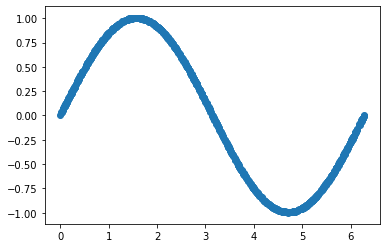

In [38]:
M = 1200

# sample from the x axis M points
x = np.random.rand(M) * 2*math.pi

# add noise
eta = np.random.rand(M) * 0.01

# compute the function
y = np.sin(x) + eta

# plot
_ = plt.scatter(x,y)

In [39]:
# use the NumPy-PyTorch bridge
x_train = torch.tensor(x[0:1000]).float().view(-1, 1).to(device)
y_train = torch.tensor(y[0:1000]).float().view(-1, 1).to(device)

x_test = torch.tensor(x[1000:]).float().view(-1, 1).to(device)
y_test = torch.tensor(y[1000:]).float().view(-1, 1).to(device)

In [40]:
class SineDataset(data.Dataset):
    def __init__(self, x, y):
        super(SineDataset, self).__init__()
        assert x.shape[0] == y.shape[0]
        self.x = x
        self.y = y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

sine_dataset = SineDataset(x_train, y_train)

sine_dataset_test = SineDataset(x_test, y_test)

sine_loader = torch.utils.data.DataLoader(
    sine_dataset, batch_size=32, shuffle=True)

sine_loader_test = torch.utils.data.DataLoader(
    sine_dataset_test, batch_size=32)

In [41]:
class SineModel(nn.Module):
    def __init__(self):
        super(SineModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(1, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5, 1))
        
    def forward(self, x):
        return self.network(x)

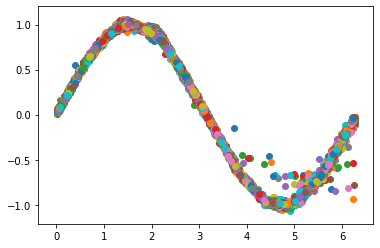

In [42]:
# declare the model
model = SineModel().to(device)

# define the criterion
criterion = nn.MSELoss()

# select the optimizer and pass to it the parameters of the model it will optimize
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

epochs = 1000

# training loop
for epoch in range(epochs):
    for i, (x_i, y_i) in enumerate(sine_loader):

        y_hat_i = model(x_i)            # forward pass
                                
        loss = criterion(y_hat_i, y_i)  # compute the loss and perform the backward pass

        optimizer.zero_grad()           # cleans the gradients
        loss.backward()                 # computes the gradients
        optimizer.step()                # update the parameters

    if epoch % 20:
        plt.scatter(x_i.data.cpu().numpy(), y_hat_i.data.cpu().numpy())

In [43]:
# testing
with torch.no_grad():
    model.eval()
    total_loss = 0.
    for k, (x_k, y_k) in enumerate(sine_loader_test):
        y_hat_k = model(x_k)
        loss_test = criterion(y_hat_k, y_k)
        total_loss += float(loss_test)

print(total_loss)

0.0022552500595338643


## Reproducibility

In [44]:
def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    # For atomic operations there is currently 
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    #
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    np.random.seed(seed)

enforce_reproducibility()

## References

Lapan, Maxim (2018) *Deep Reinforcement Learning Hands-On*. Birmingham: Packt Publishing

Rao, Delip and Brian McMahan (2019) *Natural Language Processing with PyTorch*. Sebastopol, CA: O'Reilly Media